# BLOB Analysis in Python 

Start by importing some function:

In [1]:
from skimage import io, color, morphology
from skimage.morphology import erosion, dilation, opening, closing, disk
from skimage.util import img_as_float, img_as_ubyte
import matplotlib.pyplot as plt
import numpy as np
import math
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage import measure
from skimage.color import label2rgb

and define a convenience function to show two images side by side:

In [2]:
def show_comparison(original, modified, modified_name):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4), sharex=True,
                                   sharey=True)
    ax1.imshow(original)
    ax1.set_title('Original')
    ax1.axis('off')
    ax2.imshow(modified, cmap=plt.cm.gray )
    ax2.set_title(modified_name )
    ax2.axis('off')
    io.show()

## LEGO Classification

We will start by trying some BLOB analysis approaches on a photo of some Lego bricks: **lego_4_small.png**.

### Exercise 1: Binary image from original image

Read the image, convert it to grayscale and use *Otsus* method to compute and apply a threshold. 

Show the binary image together with the original image.

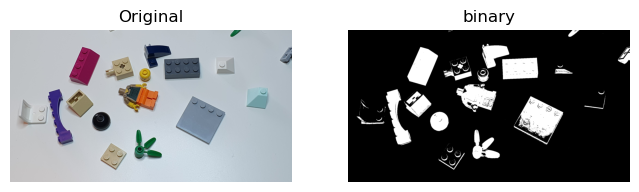

In [3]:
lego_image= io.imread("data/lego_4_small.png")
lego_gray = color.rgb2gray(lego_image)
threshold_value = threshold_otsu(lego_gray)
bin_img = threshold_value  >=  lego_gray
show_comparison(lego_image, bin_img, 'binary')

### Exercise 2: Remove border BLOBs

Use `segmentation.clear_border` to remove border pixels from the binary image.


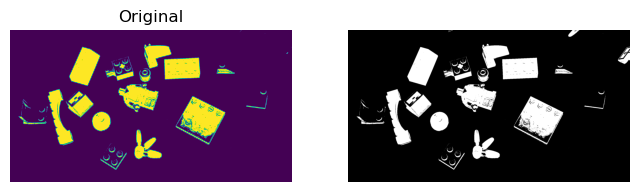

In [4]:
segmentation = clear_border(bin_img)
show_comparison(segmentation, bin_img, '')


### Exercise 3: Cleaning using morphological operations

In order to remove remove noise and close holes, you should do a morphological closing followed by a morphological opening with a disk shaped structuring element with radius 5. See [Exercise 4b](https://github.com/RasmusRPaulsen/DTUImageAnalysis/tree/main/exercises/ex4b-ImageMorphology) if you are in doubt.

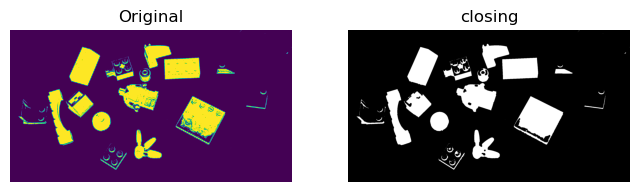

In [5]:
footprint = disk(5)
closed = morphology.binary_closing(segmentation, footprint)
show_comparison(segmentation, closed, 'closing')

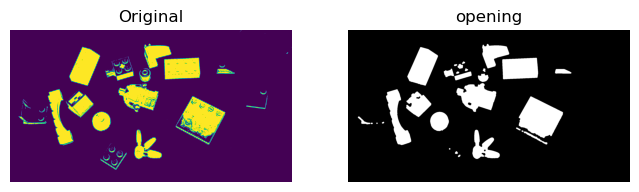

In [6]:
opened = morphology.binary_opening(closed, footprint)
show_comparison(segmentation, opened, 'opening')

### Exercise 4: Find labels

The actual connected component analysis / BLOB analysis is performed using `measure.label` :

In [7]:
label_img = measure.label(opened)
n_labels = label_img.max()
print(f"Number of labels: {n_labels}")

Number of labels: 29


### Exercise 5: Visualize found labels

We can use the function `label2rbg` to create a visualization of the found BLOBS. Show this together with the original image.

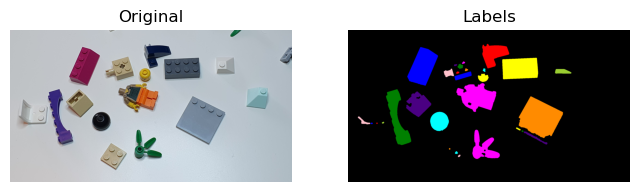

In [8]:
labels = label2rgb(label_img)
show_comparison(lego_image, labels, 'Labels')

### Exericse 6: Compute BLOB features

It is possible to compute a wide variety of BLOB features using the `measure.regionprops` function:

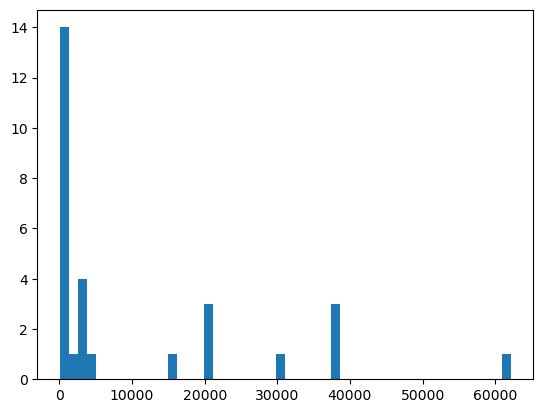

In [9]:
region_props = measure.regionprops(label_img)
areas = np.array([prop.area for prop in region_props])
plt.hist(areas, bins=50)
plt.show()

### Exercise 7: Exploring BLOB features

There is an example program called `Ex5-BlobAnalysisInteractive.py` in the [exercise material folder](https://github.com/RasmusRPaulsen/DTUImageAnalysis/tree/main/exercises/ex5-BLOBAnalysis/data).

With that program, you can explore different BLOB features interactively. It requires installation of `plotly`:

The raw images from the Cytometer are 1920x1440 pixels and each pixel is 16 bit (values from 0 to 65535). The resolution is 1.11 $\mu m$ / pixel.

To make it easier to develop the cell counting program we start by working with smaller areas of the raw images. The images are also converted to 8 bit grayscale images:

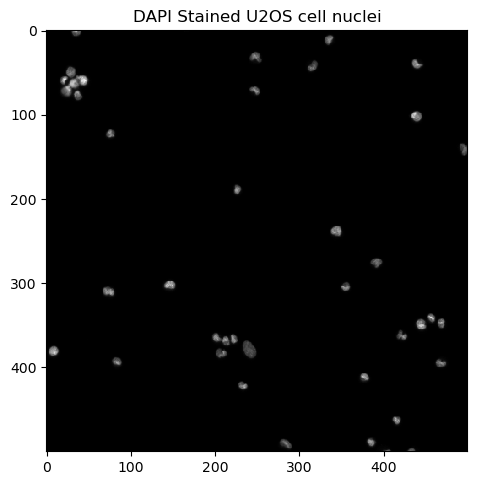

In [10]:
in_dir = "data/"
img_org = io.imread(in_dir + 'Sample E2 - U2OS DAPI channel.tiff')
# slice to extract smaller image
img_small = img_org[700:1200, 900:1400]
img_gray = img_as_ubyte(img_small) 
io.imshow(img_gray, vmin=0, vmax=150)
plt.title('DAPI Stained U2OS cell nuclei')
io.show()

As can be seen we use *slicing* to extract a part of the image. You can use `vmin` and `vmax` to visualise specific gray scale ranges (0 to 150 in the example above). Adjust these limits to find out where the cell nuclei are most visible.

Initially, we would like to apply a threshold to create a binary image where nuclei are foreground. To select a good threshold, inspect the histogram:

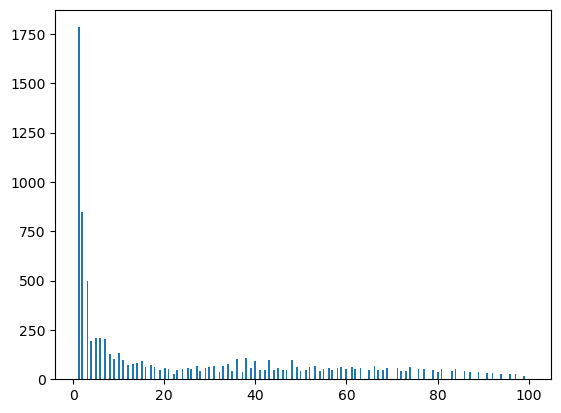

In [11]:
# avoid bin with value 0 due to the very large number of background pixels
plt.hist(img_gray.ravel(), bins=256, range=(1, 100))
io.show()

### Exercise 8: Threshold selection
Select an appropriate threshold, that seperates nuclei from the background. You can set it manually or use *Otsus* method.

Show the binary image together with the original image and evaluate if you got the information you wanted in the binary image.


It can be seen that there is some noise (non-nuclei) present and that some nuclei are connected. Nuclei that are overlapping very much should be discarded in the analysis. However, if they are only touching each other a little we can try to separate them. More on this later.

To make the following analysis easier the objects that touches the border should be removed.

29


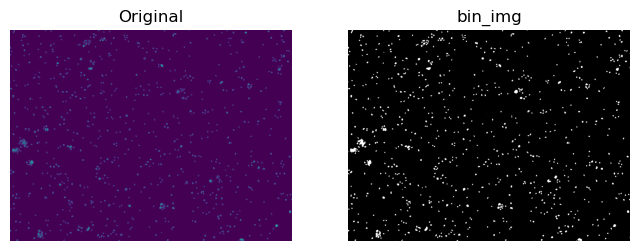

In [32]:
threshold_value = threshold_otsu(img_gray)
print(threshold_value)
bin_img = threshold_value  <  img_gray
show_comparison(img_org, bin_img, 'bin_img')

### Exercise 9: Remove border BLOBS

Use `segmentation.clear_border` to remove border pixels from the binary image.


To be able to analyse the individual objects, the objects should be
labelled.

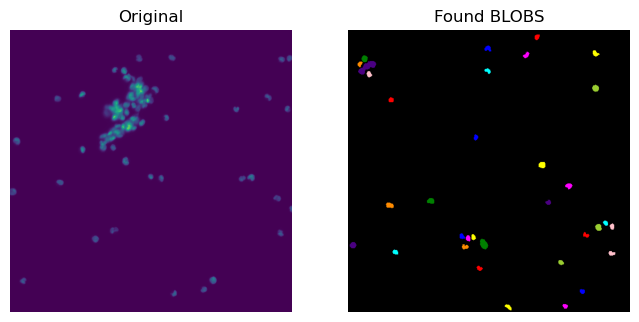

In [13]:
segmentation = clear_border(bin_img)
label_img = measure.label(segmentation)
image_label_overlay = label2rgb(label_img)
show_comparison(img_org, image_label_overlay, 'Found BLOBS')


### Exercise 10: BLOB features

The task is now to find some **object features** that identify the cell nuclei and let us remove noise and connected nuclei. We use the function `regionprops` to compute a set of features for each object:


71.0
[ 71.  88.  84.  78. 104. 360.  60.  68.  76. 115.  67.  63. 114.  93.
 107.  66. 106.  61.  68. 111.  68.  73.  64.  71. 192. 103.  78.  69.
  73.  68.  65.  63.  75.  60.]


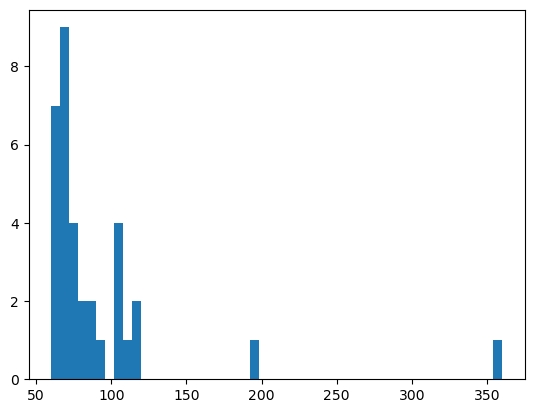

In [14]:
region_props = measure.regionprops(label_img)
print(region_props[0].area)
areas = np.array([prop.area for prop in region_props])
print(areas)
plt.hist(areas, bins=50)
plt.show()

We can try if the area of the objects is enough to remove invalid object. Plot a histogram of all the areas and see if it can be used to identify well separated nuclei from overlapping nuclei and noise. You should probably play around with the number of bins in your histogram plotting function.

### Exercise 11: BLOB classification by area

Select a minimum and maximum allowed area and use the following to visualise the result:

In [15]:
min_area = 10
max_area = 150

[[55 36]
 [55 37]
 [55 39]
 [55 40]
 [55 41]
 [55 42]
 [55 43]
 [55 44]
 [55 45]
 [56 36]
 [56 37]
 [56 38]
 [56 39]
 [56 40]
 [56 41]
 [56 42]
 [56 43]
 [56 44]
 [56 45]
 [56 46]
 [56 47]
 [57 35]
 [57 36]
 [57 37]
 [57 38]
 [57 39]
 [57 40]
 [57 41]
 [57 42]
 [57 43]
 [57 44]
 [57 45]
 [57 46]
 [57 47]
 [57 48]
 [58 34]
 [58 35]
 [58 36]
 [58 37]
 [58 38]
 [58 39]
 [58 40]
 [58 41]
 [58 42]
 [58 43]
 [58 44]
 [58 45]
 [58 46]
 [58 47]
 [58 48]
 [59 30]
 [59 31]
 [59 32]
 [59 33]
 [59 34]
 [59 35]
 [59 36]
 [59 37]
 [59 38]
 [59 39]
 [59 40]
 [59 41]
 [59 42]
 [59 43]
 [59 44]
 [59 45]
 [59 46]
 [59 47]
 [59 48]
 [59 49]
 [60 29]
 [60 30]
 [60 31]
 [60 32]
 [60 33]
 [60 34]
 [60 35]
 [60 36]
 [60 37]
 [60 38]
 [60 39]
 [60 40]
 [60 41]
 [60 42]
 [60 43]
 [60 44]
 [60 45]
 [60 46]
 [60 47]
 [60 48]
 [60 49]
 [61 28]
 [61 29]
 [61 30]
 [61 31]
 [61 32]
 [61 33]
 [61 34]
 [61 35]
 [61 36]
 [61 37]
 [61 38]
 [61 39]
 [61 40]
 [61 41]
 [61 42]
 [61 43]
 [61 44]
 [61 45]
 [61 46]
 [61 47]
 

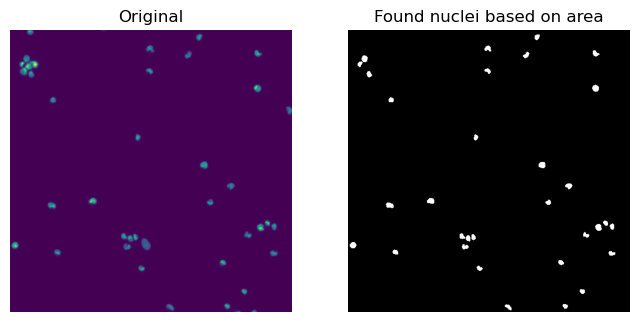

In [33]:
# Create a copy of the label_img
label_img_filter = label_img
for region in region_props:
	# Find the areas that do not fit our criteria
	if region.area > max_area or region.area < min_area:
		# set the pixels in the invalid areas to background
		for cords in region.coords:
			label_img_filter[cords[0], cords[1]] = 0
			print(region.coords)
# Create binary image from the filtered label image
i_area = label_img_filter > 0
show_comparison(img_small, i_area, 'Found nuclei based on area')



### Exercise 12: Feature space

Extract all the perimeters of the BLOBS:

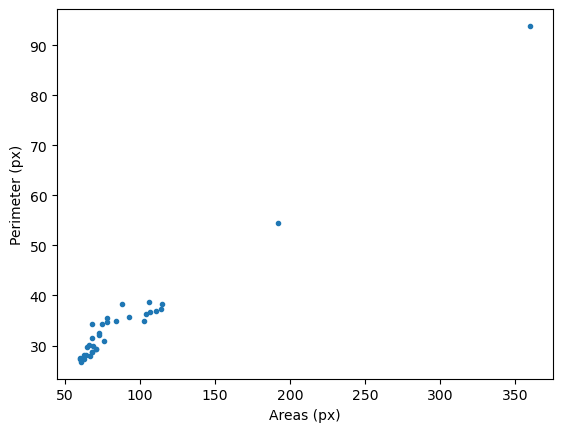

In [17]:
perimeters = np.array([prop.perimeter for prop in region_props])
fig, ax = plt.subplots(1,1)
ax.plot(areas, perimeters, '.')
ax.set_xlabel('Areas (px)')
ax.set_ylabel('Perimeter (px)')
plt.show()


### Exercise 13: BLOB Circularity
$$
f_\text{circ} = \frac{4 \pi A}{P^2},
$$

where $A$ is the object area and $P$ is the perimeter. A circle has a circularity close to 1, and very-non-circular object have circularity close to 0.

In [18]:
def circularity(area, perimeter):
    '''
    You may get values larger than 1 because
    we are in a "discrete" (pixels) domain. Check:

    CIRCULARITY OF OBJECTS IN IMAGES, Botterma, M.J. (2000)
    https://core.ac.uk/download/pdf/14946814.pdf
    '''
    f_circ = (4*np.pi*area)/(perimeter**2)
    return f_circ

circs = circularity(areas, perimeters)

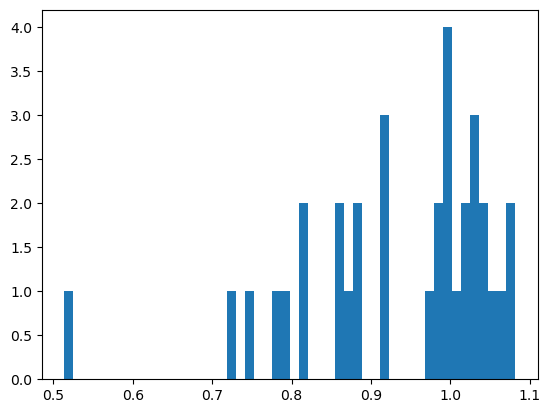

In [19]:
plt.hist(circs, bins=50)
plt.show()

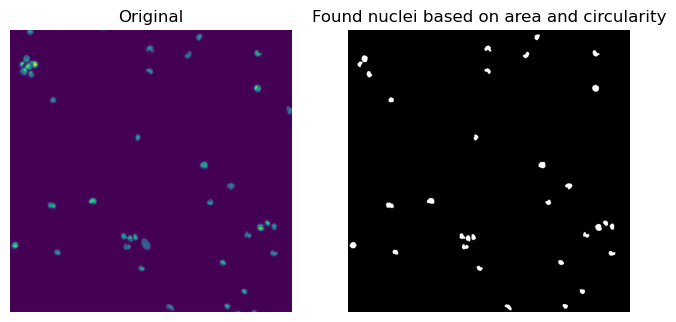

In [20]:
min_circ = 0.7
min_area = 10 
max_area = 150

# Create a copy of the label_img
label_img_filter = label_img
for region in region_props:
	circ = circularity(region.area, region.perimeter)
	# Find the areas that do not fit our criteria
	if region.area > max_area or region.area < min_area or circ < min_circ:
		# set the pixels in the invalid areas to background
		for cords in region.coords:
			label_img_filter[cords[0], cords[1]] = 0

# Create binary image from the filtered label image
i_area = label_img_filter > 0
show_comparison(img_small, i_area, 'Found nuclei based on area and circularity')

### Exercise 14: BLOB circularity and area

Try to plot the areas versus the circularity. What do you observe?

Extend your method to return the number (the count) of well-formed nuclei in the image.

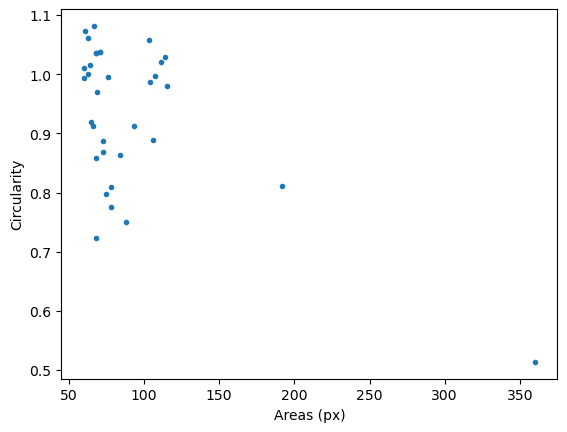

In [21]:
fig, ax = plt.subplots(1,1)
ax.plot(areas, circs, '.')
ax.set_xlabel('Areas (px)')
ax.set_ylabel('Circularity')
plt.show()

In [22]:
def cell_counting(img_gray, min_area = 10, max_area = 150, min_circ = 0.7):

    # Binarization
    thres = threshold_otsu(img_gray)
    img_bin = img_gray > thres
    img_c_b = clear_border(img_bin)

    # Label image
    label_img = measure.label(img_c_b)

    # Extract properties
    region_props = measure.regionprops(label_img)

    # Number of blobs
    n_nuclei = len(region_props)
    
    # Filter the label image
    label_img_filter = label_img.copy()
    for region in region_props:
        circ = circularity(region.area, region.perimeter)
        # Find the areas that do not fit our criteria
        if region.area > max_area or region.area < min_area or circ < min_circ:
            # set the pixels in the invalid areas to background
            n_nuclei = n_nuclei - 1
            for cords in region.coords:
                label_img_filter[cords[0], cords[1]] = 0

    # Create binary image from the filtered label image
    i_area = label_img_filter > 0

    return i_area, n_nuclei

### Exercise 15: large scale testing
Try to test the method on a larger set of training images. Use slicing to select the different regions from the raw image.

In [23]:
def im2patch(im, patch_size=[256,256]):
    """
    Fancy function to rearrange an image into patches (Not important).
    
    Arguments:
        image: a 2D image, shape (r,c).
        patch size: size of extracted paches.
    Returns:
        patches: a 3D array which in every 3rd dimension has a patch associated 
    """
    
    r,c = im.shape
    s0, s1 = im.strides    
    nrows =r-patch_size[0]+1
    ncols = c-patch_size[1]+1
    shp = patch_size[0],patch_size[1],nrows,ncols
    strd = s0,s1,s0,s1

    out_view = np.lib.stride_tricks.as_strided(im, shape=shp, strides=strd)
    out_view = out_view[:,:,::patch_size[0],::patch_size[1]].reshape(patch_size[0],patch_size[1],-1)
    return out_view

In [24]:
in_dir = "data/"
img_org = io.imread(in_dir + 'Sample E2 - U2OS DAPI channel.tiff')
img_gray = img_as_ubyte(img_org)

Number of patches 24
23


C:\Users\Leuro\AppData\Local\Temp\ipykernel_50900\2868012418.py:9: RuntimeWarning: divide by zero encountered in scalar divide
  f_circ = (4*np.pi*area)/(perimeter**2)


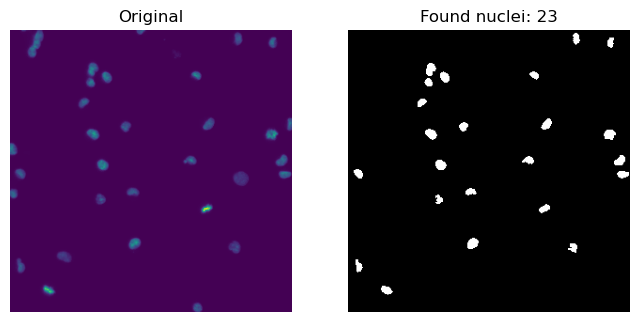

31


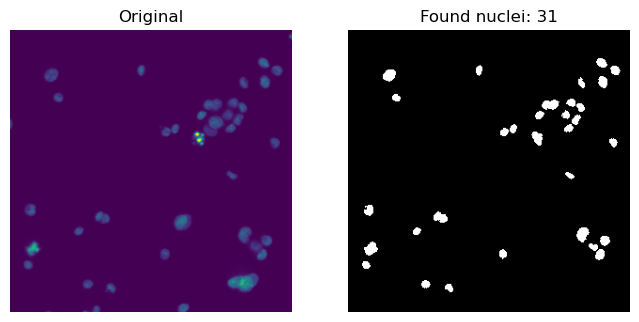

24


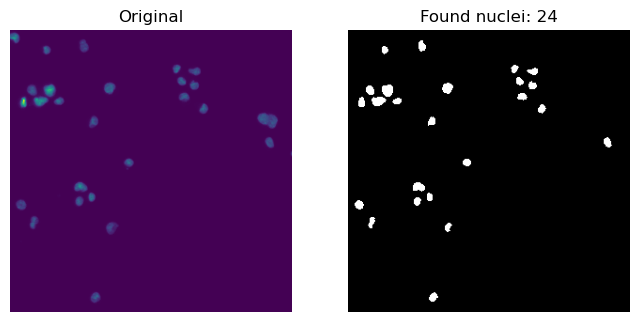

18


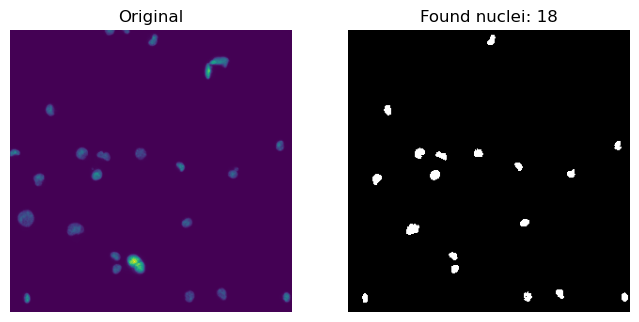

10


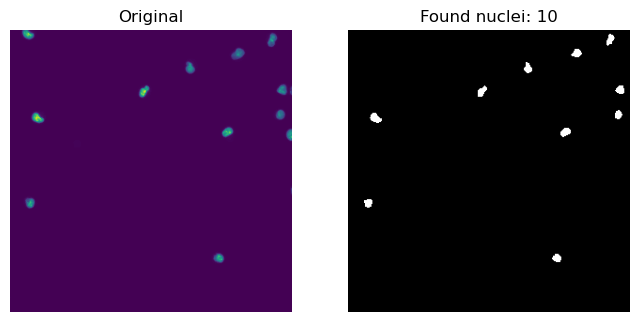

18


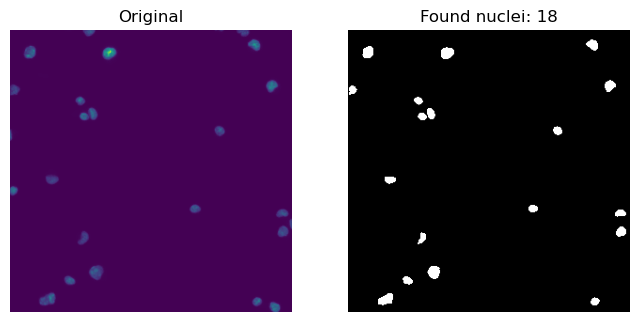

In [34]:
patches = im2patch(img_gray, patch_size=[300,300])
print(f'Number of patches {patches.shape[-1]}')

for idx_patch in range(6):
    patch = patches[:,:,idx_patch]
    filt_label, n_nuclei = cell_counting(patch)
    print(n_nuclei)
    show_comparison(patch, filt_label, f'Found nuclei: {n_nuclei}')

### Exercise 16: COS7 cell classification

Try your method on the **Sample G1 - COS7 cells DAPI channel.tiff** image.  COS7 cells are [African Green Monkey Fibroblast-like Kidney Cells](www.cos-7.com) used for a variety of research purposes.

Number of patches 24


C:\Users\Leuro\AppData\Local\Temp\ipykernel_50900\2868012418.py:9: RuntimeWarning: divide by zero encountered in scalar divide
  f_circ = (4*np.pi*area)/(perimeter**2)


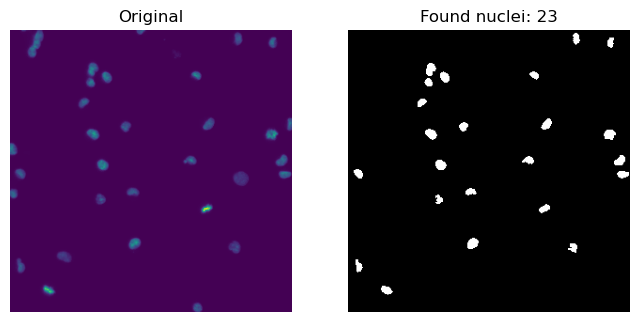

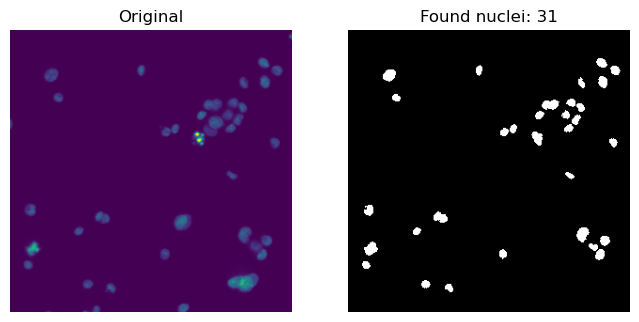

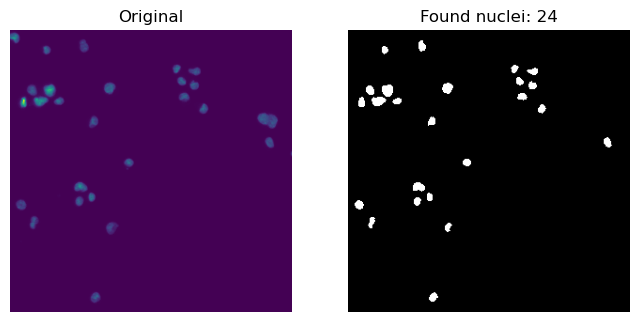

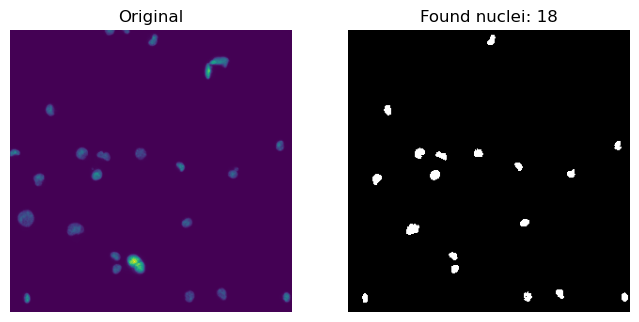

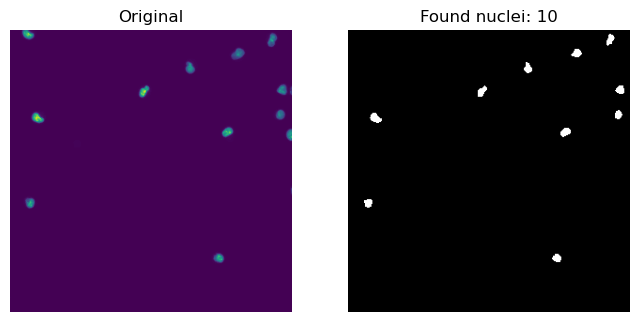

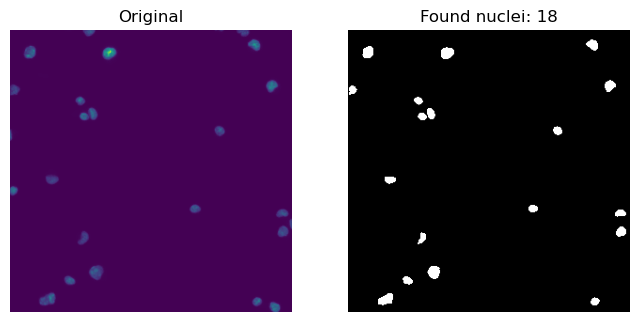

In [26]:
img_org = io.imread(in_dir + 'Sample G1 - COS7 cells DAPI channel.tiff')
img_gray = img_as_ubyte(img_org)

patches = im2patch(img_gray, patch_size=[300,300])
print(f'Number of patches {patches.shape[-1]}')

for idx_patch in range(6):
    patch = patches[:,:,idx_patch]
    filt_label, n_nuclei = cell_counting(patch)
    show_comparison(patch, filt_label,  f'Found nuclei: {n_nuclei}')

### Exercise 17: Handling overlap

In certain cases cell nuclei are touching and are therefore being treated as one object. It can sometimes be solved using for example the morphological operation **opening** before the object labelling. The operation **erosion** can also be used but it changes the object area.

In [27]:
def cell_counting_ex17(img_gray, opening_sz = 5, min_area = 10, max_area = 150, min_circ = 0.7):

    # Binarization
    thres = threshold_otsu(img_gray)
    img_bin = img_gray > thres
    img_c_b = clear_border(img_bin)
    img_open = morphology.binary_opening(img_c_b, morphology.disk(opening_sz))

    # Label image
    label_img = measure.label(img_open)

    # Extract properties
    region_props = measure.regionprops(label_img)
    
    # Number of blobs
    n_nuclei = len(region_props)
    
    # Filter the label image
    label_img_filter = label_img.copy()
    for region in region_props:
        circ = circularity(region.area, region.perimeter)
        # Find the areas that do not fit our criteria
        if region.area > max_area or region.area < min_area or circ < min_circ:
            n_nuclei = n_nuclei - 1
            # set the pixels in the invalid areas to background
            for cords in region.coords:
                label_img_filter[cords[0], cords[1]] = 0

    # Create binary image from the filtered label image
    i_area = label_img_filter > 0

    return i_area, n_nuclei

Number of patches 24


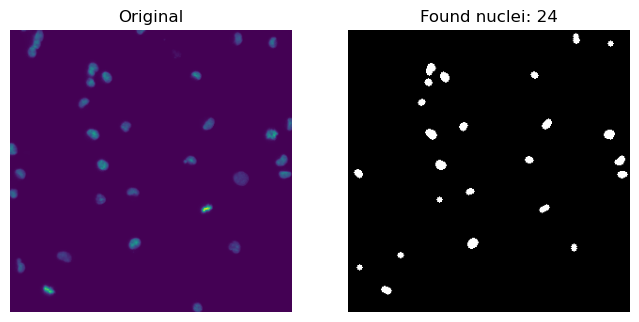

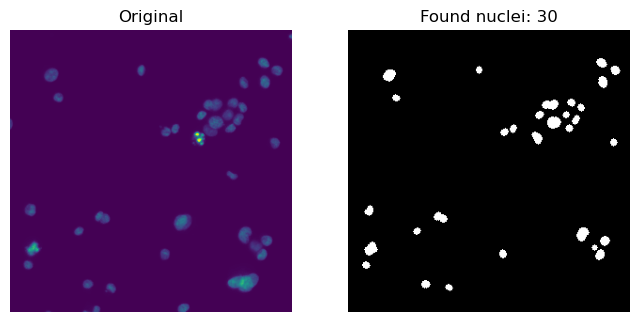

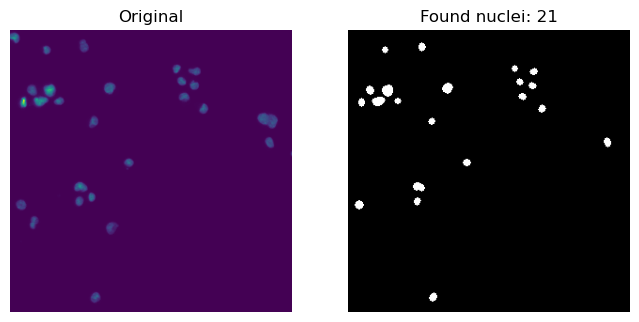

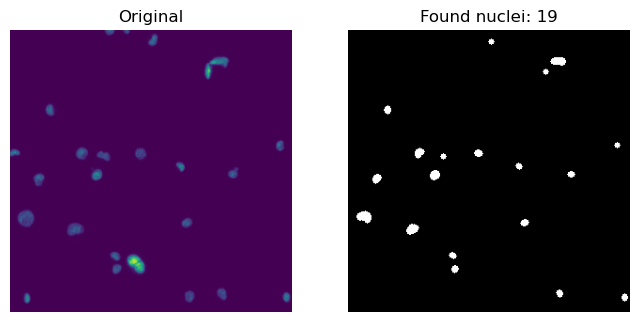

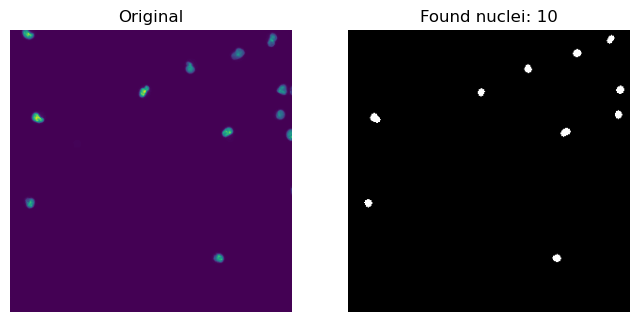

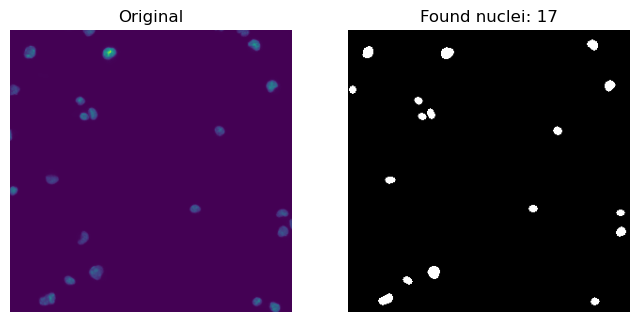

In [28]:
img_org = io.imread(in_dir + 'Sample G1 - COS7 cells DAPI channel.tiff')
img_gray = img_as_ubyte(img_org)

patches = im2patch(img_gray, patch_size=[300,300])
print(f'Number of patches {patches.shape[-1]}')

for idx_patch in range(6):
    patch = patches[:,:,idx_patch]
    filt_label, n_nuclei = cell_counting_ex17(patch, opening_sz = 3)
    show_comparison(patch, filt_label, f'Found nuclei: {n_nuclei}')